# Baseline solution based on GPT-4 prompting

## Imports and data read

In [115]:
import pandas as pd
import numpy as np

from openai import OpenAI
from sklearn.metrics import accuracy_score, f1_score

In [72]:
with open('./data_provided/kyiv_digital_sentiment_annotation/kyiv_digital_sentiment_annotation_annotator_x.tsv','r', encoding='utf-8') as file_tsv:
    df=list(file_tsv)
    df=[e.replace('\n','').split('\t')[0:2] for e in df] #[1:652]

In [73]:
df = pd.DataFrame(df, columns=['content', 'label'])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  564 non-null    object
 1   label    564 non-null    object
dtypes: object(2)
memory usage: 8.9+ KB


In [75]:
df.drop(0, inplace=True)

In [76]:
df.label.unique()

array(['Negative', 'Positive', 'Neutral'], dtype=object)

Examples of inconsistencies: 

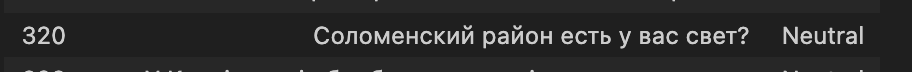

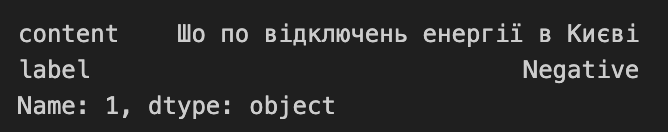

## System prompt creation

In [59]:
system_prompt = '''

You are a Ukrainian professional social network analyst. You need to analyze peoples emotions and define the comments sentiment from the Ukrainian social media. The input you receive is a text from Telegram messenger. The text can be Ukrainian or Russian. 

Your output must be a single word from the following list: ['positive', 'neutral', 'negative']. 
Here are some examples of inputs to you and your outputs expected:

```
Input: 'Киеве продолжать звучать взрывы. СМИ сообщают, что в ряде районов пропал свет.'
Output: 'negative'

Input: 'Через обстріли у Києві знеструмлено майже 260 тисяч споживачів, відключалося обладнання підстанцій у Київській області, — Міненерго   У Києві пошкоджено повітряну лінію, без напруги низка підстанцій – знеструмлені 259 тисяч точок обліку.'
Output: 'negative'

Input: 'Попередній висновок🧐  Перше. У нас найкраще в світі ППО! Жодна країна не витримала б такої масованої атаки. Досвід і наявність засобів вберігають 99% населення  Друге. Русня просто вчергове хоче нас залякати, але минулої зими і в травні ми чітко вивчили алгоритми безпеки і хєр кладем русакам на воротнік  Третє. Не бійтеся, скоро і вода і електрика повернуться, а воля наша не зламається!  Інформує Київ | Надіслати новину'
Output: 'positive'

Input: 'Голосеевский р-н есть свет 😉✌🏻'
Output: 'positive'

Input: 'Підкажіть, будь ласка, чи бувають на Видубичах на платформах міської і приміських електричок?'
Output: 'neutral'
```

Remember that the 'sentiment' values can be only and only from the following list: ['positive', 'neutral', 'negative']. 

'''

In [60]:
print(len(system_prompt)/4)

391.25


## Pipeline

https://platform.openai.com/docs/api-reference/authentication

In [ ]:
api_key = 'sk-proj-7yyg4KC696T7WK6CmLeWT3BlbkFJfjiC6bs5r8R7yoGLCIUP'

In [96]:
client = OpenAI(api_key=api_key)

In [100]:
def analyze_sentiment(comment):
    """
    Sends a request to OpenAI's GPT model to analyze sentiment.
    """
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": comment}
        ]
    )   
    return response.choices[0].message.content

In [101]:
example_comment = 'У деяких районах Києва зникло світло.'

In [102]:
sentiment_result = analyze_sentiment(example_comment)

In [103]:
print("Sentiment Analysis Result:", sentiment_result)

Sentiment Analysis Result: 'negative'


In [104]:
gpt_answers = []

for id in df.index:
    gpt_answers.append(analyze_sentiment(df.loc[id, 'content']))

In [105]:
df['gpt_labels'] = gpt_answers

In [107]:
df['gpt_labels'].value_counts()

gpt_labels
'negative'    253
'positive'    128
'neutral'     123
negative       44
neutral         8
positive        7
Name: count, dtype: int64

In [111]:
df.loc[df['gpt_labels'] == "'negative'", 'gpt_labels'] = 'negative'
df.loc[df['gpt_labels'] == "'positive'", 'gpt_labels'] = 'positive'
df.loc[df['gpt_labels'] == "'neutral'", 'gpt_labels'] = 'neutral'

In [112]:
df['gpt_labels'].value_counts()

gpt_labels
negative    297
positive    135
neutral     131
Name: count, dtype: int64

In [113]:
df['label'].value_counts()

label
Negative    323
Positive    169
Neutral      71
Name: count, dtype: int64

In [ ]:
df['y'] = df['label'].apply(lambda x: {'Negative': -1, 'Neutral': 0, 'Positive': 1}[x])

In [ ]:
df['y_hat'] = df['gpt_labels'].apply(lambda x: {'negative': -1, 'neutral': 0, 'positive': 1}[x])

In [ ]:
df

,content,label,gpt_labels,y,y_hat
1,Шо по відключень енергії в Києві,Negative,neutral,-1,0
2,Збудували фізичний захист для енергообʼєктів К...,Positive,positive,1,1
3,"Так я ж тебе задал вопрос. Киев, май, первое п...",Positive,positive,1,1
4,Аварії,Negative,negative,-1,-1
5,"У вас давно вже щось відпадає,а ви ще до цих п...",Negative,negative,-1,-1
...,...,...,...,...,...
559,‼️Київ. Запрошуємо до співпраці у велику компа...,Positive,positive,1,1
560,Я не я і хата метро не моє. Десь таке загальне...,Negative,negative,-1,-1
561,У меня соседа в начале января приняли на Троещ...,Neutral,neutral,0,0
562,Обґрунтований тариф на проїзд у Київському мет...,Negative,negative,-1,-1


## Metrics

In [136]:
def evaluate_gpt_results(df):
    """
    Computes accuracy and F1-score for GPT sentiment analysis results.
    
    Parameters:
    df (pd.DataFrame): A DataFrame containing 'true_label' and 'gpt_label'.
    
    Returns:
    dict: A dictionary with accuracy and F1-score.
    """
    accuracy = accuracy_score(df['y'], df['y_hat'])
    f1 = f1_score(df['y'], df['y_hat'], average='weighted')
    
    return {"accuracy": round(accuracy, 4), "f1_score": round(f1, 4)}

In [137]:
metrics = evaluate_gpt_results(df)

In [138]:
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'accuracy': 0.7798, 'f1_score': 0.7985}
